In [21]:
import os
import argparse
import numpy as np
import pandas as pd
import datetime as dt

bt_dir = '../adr_results/1400_all_gbp_eur_single_time'
pnl = pd.read_csv(os.path.join(bt_dir, 'pnl.csv', ), index_col=0, parse_dates=True)
pnl.columns = ['pnl']
gmv = pd.read_csv(os.path.join(bt_dir, 'gmv.csv'), index_col=0, parse_dates=True)
gmv.columns = ['gmv']
trade_df = pd.read_csv(os.path.join(bt_dir, 'trades.csv'))
trade_df['commission'] = 0.0006 * trade_df['size'].abs()
close_idx = trade_df['timestamp'].str[11:13] == '16'
trade_df.loc[close_idx, 'exchange_fee'] = 0.0016 * trade_df.loc[close_idx, 'size'].abs()
trade_df.loc[~close_idx, 'exchange_fee'] = -0.0018 * trade_df.loc[~close_idx, 'size'].abs()
trade_df['date'] = pd.to_datetime(trade_df['timestamp'].str[:10])

In [22]:
daily_fees = trade_df.groupby('date')[['commission', 'exchange_fee']].sum()
merged = pnl.merge(daily_fees, left_index=True, right_index=True)
merged['pnl_after_fees'] = merged['pnl'] - merged['commission'] - merged['exchange_fee']
merged = merged.merge(gmv, left_index=True, right_index=True)

In [23]:
trade_df = pd.read_csv(os.path.join(bt_dir, 'trades.csv'))
trade_df['timestamp'] = pd.to_datetime(trade_df['timestamp'], utc=True, format='mixed')
trades = trade_df.groupby(['timestamp','ticker']).last().reset_index()
trades['pos'] = trades.groupby('ticker')['size'].transform('cumsum')
pos = trades.pivot(index='timestamp',columns='ticker',values='pos').ffill().fillna(0)
price = trades.pivot(index='timestamp',columns='ticker',values='price').ffill().fillna(0)
all_gmv = (pos * price).abs().sum(axis=1)
max_gmv = all_gmv.max()
mean_gmv = all_gmv.resample('1min').min().mean()

Text(0.95, 0.7, 'Total PnL: $4,174,000\nAnnualized PnL: 1,852,000\nAnnualized Return: 19.99%\nAnnualized Sharpe: 7.31\n')

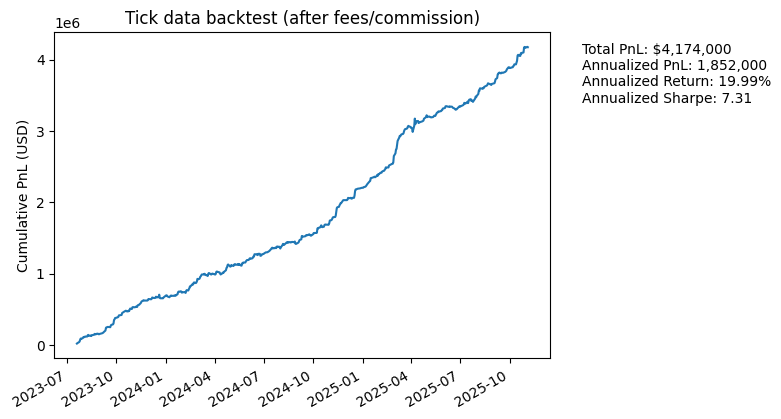

In [24]:
import matplotlib.pyplot as plt

merged['pnl_after_fees'].cumsum().plot()
plt.title('Tick data backtest (after fees/commission)')
plt.ylabel('Cumulative PnL (USD)')
# Displaying metrics in whitespace outside of plot, with commas as thousands separators:
plt.figtext(.95, 0.7, f"Total PnL: ${merged['pnl_after_fees'].sum().round(-3):,.0f}\n"
                        f"Annualized PnL: {(252 * merged['pnl_after_fees'].sum() / len(merged)).round(-3):,.0f}\n"
                        f"Annualized Return: {252 * merged['pnl_after_fees'].mean() / mean_gmv:.2%}\n"
                       f"Annualized Sharpe: {np.sqrt(252) * merged['pnl_after_fees'].mean()/merged['pnl_after_fees'].std():.2f}\n")

In [5]:
import os
import pandas as pd

price_filename = '../data/raw/adrs/adr_PX_LAST_adjust_none.csv'
trade_df = pd.read_csv(os.path.join(bt_dir, 'trades.csv'))
trade_df['timestamp'] = pd.to_datetime(trade_df['timestamp'], utc=True)

price_df = pd.read_csv(price_filename, index_col=0, parse_dates=True)
trade_df['date'] = trade_df['timestamp'].dt.date

position_df = trade_df[['date','ticker','size']].groupby(['date','ticker'])['size'].sum().unstack().fillna(0).cumsum()
notional_trade_df = trade_df.copy()
notional_trade_df['value'] = notional_trade_df['size'] * notional_trade_df['price']

cash_flow = -notional_trade_df.groupby(['date','ticker'])['value'].sum()

    
position_change = position_df.diff()
position_change.iloc[0] = position_df.iloc[0]
position_value = (position_df * price_df.loc[position_df.index, position_df.columns])

pnl = (position_value - position_value.shift(fill_value=0)) + cash_flow
gmv = position_value.abs()

In [6]:
cash_flow.unstack().sum().sort_values()

ticker
AEG      -81213.605
NGG      -31177.220
NWG      -30845.525
SNN      -23452.490
RELX     -13373.630
PSO      -10874.600
E         -8111.540
FMS        -509.665
BCS         211.040
RIO       12915.425
WPP       22244.855
IHG       30316.710
ASML      30533.720
NOK       34114.175
PUK       38644.770
BP        56786.230
HSBC      57365.220
RTO       83485.585
PHG       92849.200
SAN      100178.735
BUD      105251.730
SNY      111851.745
ING      118933.565
SAP      152917.490
DB       154970.835
VOD      172719.930
DEO      178530.370
HLN      189427.070
BBVA     197936.310
UL       202271.970
BTI      217977.205
LYG      258979.885
RYAAY    315548.670
AZN      322855.325
TS       327729.535
TTE      328960.985
ARGX     380347.510
SHEL     427011.905
GSK      526127.085
dtype: float64

In [7]:
by_ticker = cash_flow.unstack()
by_ticker.index = pd.to_datetime(by_ticker.index)


In [8]:
by_ticker['GSK'].sort_values()

date
2024-06-26    -18100.740
2025-06-18    -15431.325
2025-03-31    -11696.715
2025-10-03    -11621.155
2024-01-31    -10709.770
                 ...    
2025-04-30     16955.690
2025-10-23     19244.000
2025-07-17     24423.960
2025-07-31     27334.350
2024-10-09    373688.980
Name: GSK, Length: 568, dtype: float64

In [9]:
open_df = trade_df.sort_values('timestamp').groupby(['ticker','date']).first().reset_index()
open_df['val'] = open_df['size'] * open_df['price']
open_df['val'].sort_values()


1262    -2000313.945
17572   -2000110.380
5759    -2000067.660
17470   -2000041.125
18129   -2000032.320
            ...     
17569    2000080.175
17267    2000094.495
17530    2000096.955
1047     2000124.870
17481    2000138.350
Name: val, Length: 22150, dtype: float64

In [10]:
trade_df['date']

0        2023-07-20
1        2023-07-20
2        2023-07-20
3        2023-07-20
4        2023-07-20
            ...    
44295    2025-11-04
44296    2025-11-04
44297    2025-11-04
44298    2025-11-04
44299    2025-11-04
Name: date, Length: 44300, dtype: object

In [11]:
trade_df[(trade_df['ticker']=='GSK') & (trade_df['timestamp'].dt.strftime('%Y-%m-%d')=='2024-10-09')]

,timestamp,ticker,size,price,date
23736,2024-10-09 13:00:00+00:00,GSK,58988,33.905,2024-10-09
23737,2024-10-09 16:00:00+00:00,GSK,-58988,40.240,2024-10-09


In [12]:
close_df = trade_df.sort_values('timestamp').groupby(['ticker','date']).last().reset_index()
prices = close_df[['date','ticker','price']].merge(open_df[['date','ticker','price']], on=['date','ticker'], suffixes=('_close','_open'))
prices['date'] = pd.to_datetime(prices['date']).dt.strftime('%Y-%m-%d')
((prices['price_open'] - prices['price_close'])>0).sum()/len(prices)

0.4927313769751693

In [13]:
prices[prices['date'] == '2024-10-09']

,date,ticker,price_close,price_open
304,2024-10-09,AEG,6.240,6.225
872,2024-10-09,ARGX,520.520,516.040
1440,2024-10-09,ASML,845.900,842.290
2008,2024-10-09,AZN,77.505,77.155
2576,2024-10-09,BBVA,10.150,10.145
3144,2024-10-09,BCS,12.190,12.195
3712,2024-10-09,BP,31.980,31.945
4279,2024-10-09,BTI,35.480,35.495
4847,2024-10-09,BUD,64.270,64.425
5415,2024-10-09,DB,17.500,17.495


/tmp/ipykernel_927437/675182950.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sign_df = open_df.pivot(index='date', columns='ticker', values='sign').fillna(0)


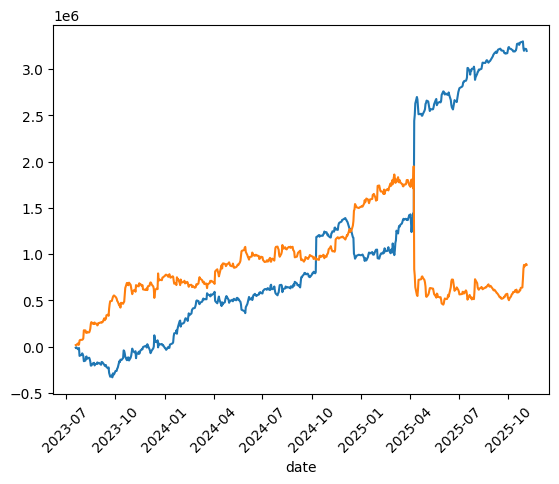

In [14]:
open_df['sign']=(open_df['val']>1)
sign_df = open_df.pivot(index='date', columns='ticker', values='sign').fillna(0)
long_pnl = (sign_df * by_ticker).sum(axis=1)
short_pnl = (~sign_df * by_ticker).sum(axis=1)

long_pnl.cumsum().plot(label='Long PnL')
short_pnl.cumsum().plot(label='Short PnL')
plt.xticks(rotation=45);

In [17]:
gsk_df = pd.read_parquet('../data/raw/adrs/bbo-1m/nbbo/ticker=GSK')
gsk_df.loc['2025-10-09 13:30:00'][['nbbo_bid','nbbo_ask','nbbo_bid_sz','nbbo_ask_sz']]

nbbo_bid       43.54
nbbo_ask       43.55
nbbo_bid_sz     1434
nbbo_ask_sz      546
Name: 2025-10-09 13:30:00-04:00, dtype: object

In [18]:
ticker = 'DB'
db_df = pd.read_parquet('../data/raw/adrs/bbo-1m/nbbo/ticker=DB')
db_df.loc['2025-10-09 13:30:00'][['nbbo_bid','nbbo_ask','nbbo_bid_sz','nbbo_ask_sz']]

nbbo_bid       35.04
nbbo_ask       35.05
nbbo_bid_sz     1500
nbbo_ask_sz      441
Name: 2025-10-09 13:30:00-04:00, dtype: object